### DEMDP06 
# Deterministic Optimal Economic Growth Model

Welfare maximizing social planner must decide how much society should consume and invest.  Model is of special interest because it has a known closed-form solution.

 States
     s       stock of wealth
 Actions
     k       capital investment
 Parameters
     beta    capital production elasticity
     delta   discount factor

In [1]:
%matplotlib inline
from warnings import simplefilter
simplefilter('ignore')
from demos.setup import demo, np, plt
from compecon import BasisChebyshev, DPmodel, DPoptions, qnwnorm

### =========== Approximation Structure

In [2]:
n, smin, smax = 15, 0.2, 1.0
basis = BasisChebyshev(n, smin, smax, labels=['Wealth'])
snodes = basis.nodes

# =========== Model specification

In [3]:
beta, delta = 0.5, 0.9

In [4]:
def bounds(s, i, j):
    return np.zeros_like(s), s[:]

In [5]:
def reward(s, k, i, j):
    sk = s - k
    f = np.log(sk)
    fx= - sk ** -1
    fxx = - sk ** -2
    return f, fx, fxx

In [6]:
def transition(s, k, i, j, in_, e):
    g = k ** beta
    gx = beta * k **(beta - 1)
    gxx = (beta - 1) * beta * k ** (beta - 2)
    return g, gx, gxx

In [7]:
sigma = 0.1
m=5
e,w = qnwnorm(m, -sigma**2 / 2, sigma**2)

In [8]:
growth_model = DPmodel(basis, reward, transition, bounds,
                       x=['Investment'],
                       discount=delta)

# ======== Steady-State

In [9]:
sstar = (beta * delta) ** (beta / (1 - beta))   # steady-state wealth
kstar = beta * delta * sstar                    # steady-state capital investment
vstar = np.log(sstar - kstar) / (1 - delta)     # steady-state value
pstar = 1 / (sstar * (1 - beta * delta))        # steady-state shadow price
b = 1 / (1 - delta * beta)

# ===========   Compute Analytic Solution at Collocation Nodes

In [10]:
vtrue = vstar + b * (np.log(snodes) - np.log(sstar))
ktrue = delta * beta * snodes

# Set a refined grid to evaluate the functions

In [11]:
order = np.atleast_2d([0, 1])

# ===========  Solve Bellman Equation

In [12]:
options = dict(print=True,
               algorithm='newton',
               maxit=253)

In [13]:
S = growth_model.solve(vtrue, ktrue, print=True, algorithm='newton', maxit=120)
v, pr = growth_model.Value(S.Wealth, order)
k = growth_model.Policy(S.Wealth)

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       4.7e-07    0.0120
   1       1.6e-12    0.0160
Elapsed Time =    0.02 Seconds


# ============  Simulate Model

In [14]:
T = 20
data = growth_model.simulate(T, np.atleast_2d(smin))

# ============  Compute Linear-Quadratic Approximation

In [15]:
growth_model.lqapprox(sstar, kstar)
vlq, plq = growth_model.Value(S.Wealth, order)
klq = growth_model.Policy(S.Wealth)

# ============   Compute Analytic Solution

In [16]:
vtrue = vstar + b * (np.log(S.Wealth) - np.log(sstar))

# ==============   Make plots:

In [17]:
Wealth = S.Wealth.T

# Plot Optimal Policy

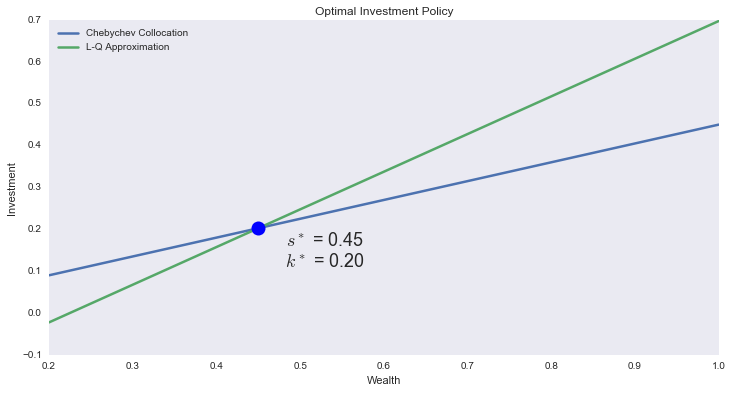

In [18]:
demo.figure('Optimal Investment Policy', 'Wealth', 'Investment')
plt.plot(Wealth, np.c_[k, klq])
demo.annotate(sstar, kstar,'$s^*$ = %.2f\n$k^*$ = %.2f' % (sstar, kstar), 'bo', (10, -7))
plt.legend(['Chebychev Collocation','L-Q Approximation'], loc = 'upper left')

# Plot Value Function

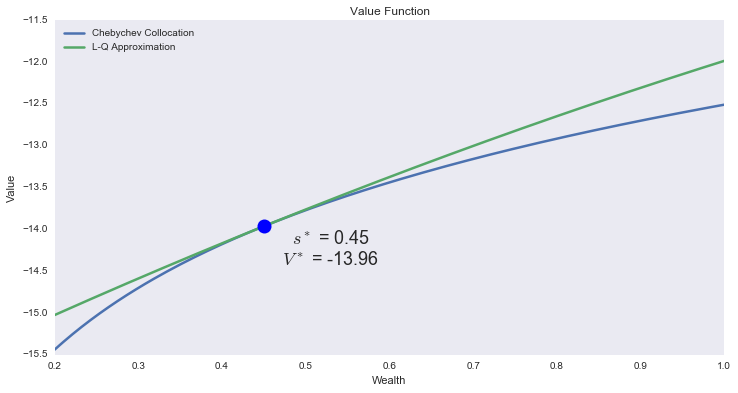

In [19]:
demo.figure('Value Function', 'Wealth', 'Value')
plt.plot(Wealth, np.c_[v, vlq])
demo.annotate(sstar, vstar,'$s^*$ = %.2f\n$V^*$ = %.2f' % (sstar, vstar),'bo', (10, -7))
plt.legend(['Chebychev Collocation','L-Q Approximation'], loc= 'upper left')

# Plot Shadow Price Function

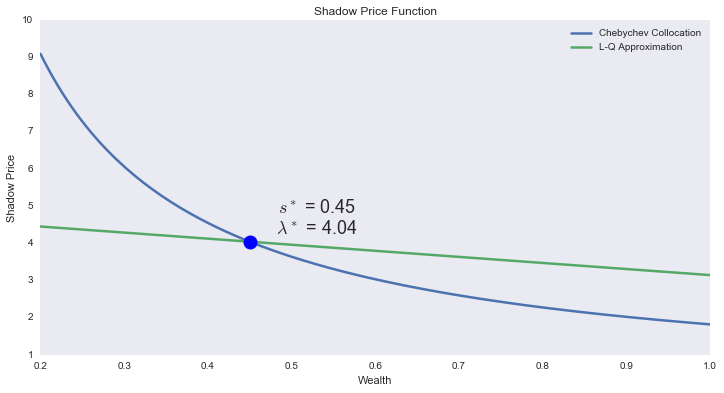

In [20]:
demo.figure('Shadow Price Function', 'Wealth', 'Shadow Price')
plt.plot(Wealth, np.c_[pr, plq])
demo.annotate(sstar, pstar,'$s^*$ = %.2f\n$\lambda^*$ = %.2f' % (sstar, pstar), 'bo', (10, 7))
plt.legend(['Chebychev Collocation','L-Q Approximation'])

# Plot Chebychev Collocation Residual and Approximation Error

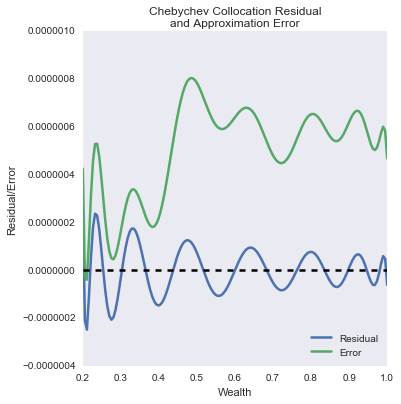

In [21]:
plt.figure(figsize=[12, 6])
demo.subplot(1, 2, 1, 'Chebychev Collocation Residual\nand Approximation Error', 'Wealth', 'Residual/Error')
plt.plot(Wealth, np.c_[S.resid, v - vtrue], Wealth, np.zeros_like(Wealth), 'k--')
plt.legend(['Residual','Error'], loc='lower right')

# Plot Linear-Quadratic Approximation Error

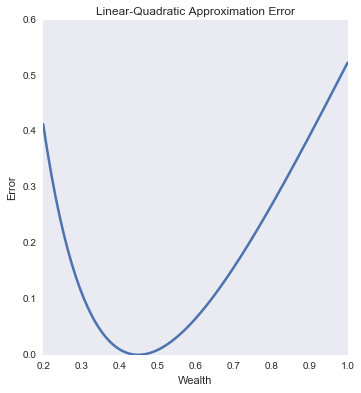

In [22]:
demo.subplot(1, 2, 2, 'Linear-Quadratic Approximation Error', 'Wealth', 'Error')
plt.plot(Wealth, vlq - vtrue)

# Plot State and Policy Paths

(0, 20.5)

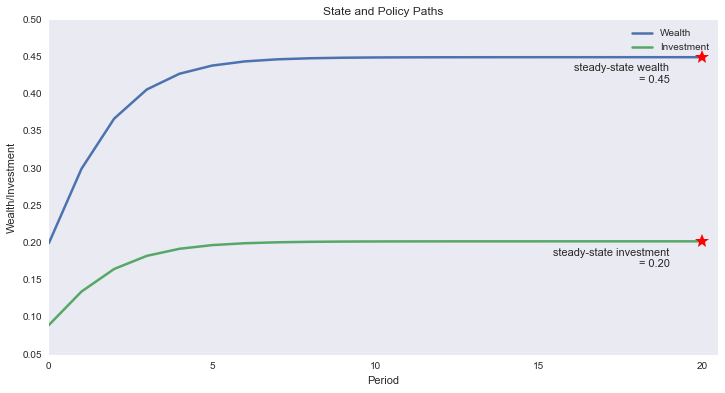

In [23]:
opts = dict(spec='r*', offset=(-5, -5), fs=11, ha='right')

data[['Wealth', 'Investment']].plot()
plt.title('State and Policy Paths')
demo.annotate(T, sstar, 'steady-state wealth\n = %.2f' % sstar, **opts)
demo.annotate(T, kstar, 'steady-state investment\n = %.2f' % kstar, **opts)
plt.xlabel('Period')
plt.ylabel('Wealth/Investment')
plt.xlim([0, T + 0.5])

# Print Steady-State

In [24]:
print('\n\nSteady-State')
print('   Wealth       = %5.4f' % sstar)
print('   Investment   = %5.4f' % kstar)

plt.show()



Steady-State
   Wealth       = 0.4500
   Investment   = 0.2025
